# NZ SEEK JOB Analysis
---

## Package loading

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

## Constant value setting

In [166]:
DICT_LINK_INDEX = {'Admin':1,'Banking':1,'Education':1,'Manufacture':1}
DICT_COMPANY_INDEX = {'Admin':2,'Banking':2,'Education':2,'Manufacture':2}
DICT_AREA_INDEX = {'Admin':3,'Banking':3,'Education':3,'Manufacture':3}
DICT_DATE_INDEX = {'Admin':4,'Banking':5,'Education':5,'Manufacture':5}
DICT_CLASSFICATION_INDEX = {'Admin':5,'Banking':6,'Education':6,'Manufacture':6}
DICT_SALARY_FLOOR = {'Admin':35000,'Banking':53000,'Education':48000,'Manufacture':24600}
DICT_SALARY_CEILING = {'Admin':55000,'Banking':85000,'Education':79000,'Manufacture':116000}
ANNUAL_WORKING_HOUR = 8*200

## Functionlized data cleaning

In [167]:
def pre_cleaning(df,i,j,k):
    df['company_name']=df[i]
    df[['posted_time','featured_at']]=df[j].str.split(',',expand=True)[[0,2]]
    df.loc[df['company_name'].isna(),'company_name']= df['featured_at']
    df['ad_type']= df[k].str.extract('\=(\w+)\#')
    return df

In [168]:
def listing_time_cleaning(df):
    df['listing_time_indays'] = df['posted_time'].str.extract('(\d+[a-z])')
    df['listing_time_indays'] = df['listing_time_indays'].str.extract('(\w+)d')
    df['listing_time_indays'].fillna('0', inplace = True)
    df['listing_time_indays'] #notice that if the ad_type is promoted, the listing time is recorded as "Featured", which means the listing times of those featured advs may be longer.
    return df

In [169]:
#useful function
def deduplication(x):
    mid = len(x)//2
    if x != 'unknown':
        return x[:mid+1]
    else:
        return 'unknown'
def smart_deduplication(x):
    trim = x.strip()
    index = (trim+trim).find(trim,1)
    if index != -1:
        return trim[:index]
    else:
        return 'unknown'

In [170]:
def location_cleaning(df,i):
    df[['location','area']] = df[i].str.split("area:",expand= True)
    df['location'] = df['location'].apply(lambda x:x[9:])
    df['location'] = df['location'].apply(smart_deduplication)
    df['area'].fillna('unknown', inplace = True)
    df['area'] = df['area'].apply(smart_deduplication)
    return df

In [171]:
def classification_cleaning(df,i):
    df[['subclassification','Classification']] = df[i].str.split('subClassification:',expand=True)
    df['subclassification'] = df['subclassification'].apply(lambda x:x[15:])
    df['Classification'].fillna('unknown', inplace = True)
    df['Classification'] = df['Classification'].apply(smart_deduplication)
    df[['mainClassification','7','subclassification']] = df['subclassification'].str.split('&',expand=True)
    df['subclassification'].fillna('unknown', inplace = True)
    return df

In [172]:
def random_salary(df,i,salary_floor,salary_ceiling):    
    df['salary']=df[i]
    df[df['salary'].str.contains('\d',na=False)]['salary']
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(' to ','-',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace('\d\%','',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(',','',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(' ','',regex=True)
    df['salary'].fillna('unknown', inplace=True)
    df[['low_salary','high_salary']] = df['salary'].str.split('-', n=1,expand=True).fillna('unknown')
    df['low_salary'] = df['low_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['high_salary'] = df['high_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['low_salary'] = df[df['low_salary'].str.contains('\d',na=False)]['low_salary'].str.replace('k', '000',regex=True)
    df['high_salary'] = df[df['high_salary'].str.contains('\d',na=False)]['high_salary'].str.replace('k', '000',regex=True)
    df['low_salary'] = df['low_salary'].fillna('unknown')
    df['high_salary'] = df['high_salary'].fillna('unknown')
    df.loc[df['low_salary'] == 'unknown', 'low_salary'] = df['high_salary']
    df.loc[df['high_salary'] == 'unknown', 'high_salary'] = df['low_salary']

    for r, row in enumerate(df['low_salary'].values):
        if row == 'unknown':
            df['low_salary'][r] = np.random.randint(salary_floor, salary_ceiling, size=1)[0]

    for r, row in enumerate(df['high_salary'].values):
        if row == 'unknown':
            df['high_salary'][r] = max(np.random.randint(salary_floor, salary_ceiling, size=1)[0], df['low_salary'][r])
    df['low_salary'] = df['low_salary'].astype('float32')
    df['high_salary'] = df['high_salary'].astype('float32')
    df.loc[df['low_salary'] < 50, 'low_salary'] =df['low_salary'] * ANNUAL_WORKING_HOUR
    df.loc[df['high_salary'] < 50, 'high_salary'] =df['high_salary'] * ANNUAL_WORKING_HOUR
    return df

In [173]:
def clean_jobs(file_name,job):
    df = pd.read_excel(file_name,engine="openpyxl",header = None)
    clean_job = (df.pipe(pre_cleaning,DICT_COMPANY_INDEX[job],DICT_DATE_INDEX[job],DICT_LINK_INDEX[job]).
        pipe(listing_time_cleaning).
        pipe(location_cleaning,DICT_AREA_INDEX[job]).
        pipe(classification_cleaning,DICT_CLASSFICATION_INDEX[job]).
        pipe(random_salary,DICT_CLASSFICATION_INDEX[job],DICT_SALARY_FLOOR[job],DICT_SALARY_CEILING[job])#salary floor and ceiling
    )
    return df

# NZ Admin jobs cleaning
---

>### data preview

In [177]:
pd.read_excel("NZ_Admin_JOBS.xlsx",engine="openpyxl",header = None).head()

,0,1,2,3,4,5
0,Administrator,https://www.seek.co.nz/job/50582301?type=promo...,NaN,location: Bay of PlentyBay of Plentyarea: Taur...,"Featured,at,Private Advertiser",classification: Administration & Office Suppor...
1,Receptionist,https://www.seek.co.nz/job/50620889?type=promo...,Avenues Orthodontics,location: Bay of PlentyBay of Plentyarea: Taur...,"Featured,at",classification: Administration & Office Suppor...
2,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=stand...,New Zealand Police,location: AucklandAuckland,"4d ago,at",classification: Administration & Office Suppor...
3,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=stand...,Kew Pacific Island Early Learning Centre,location: SouthlandSouthlandarea: Invercargill...,"1h ago,at",classification: Administration & Office Suppor...
4,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=stand...,NaN,location: CanterburyCanterburyarea: Christchur...,"4d ago,at,Private Advertiser",classification: Administration & Office Suppor...


>### data after cleaning

In [179]:
df = clean_jobs("NZ_Admin_JOBS.xlsx",'Admin') #input the file name
df[['company_name', 'ad_type','listing_time_indays','location','area','Classification','low_salary','high_salary']].head()

,company_name,ad_type,listing_time_indays,location,area,Classification,low_salary,high_salary
0,Private Advertiser,promoted,0,Bay of Plenty,Tauranga,Office Management,47367.0,47367.0
1,Avenues Orthodontics,promoted,0,Bay of Plenty,Tauranga,Receptionists,52886.0,52886.0
2,New Zealand Police,standard,4,Auckland,unknown,Other,48233.0,48233.0
3,Kew Pacific Island Early Learning Centre,standard,0,Southland,Invercargill,Administrative Assistants,36719.0,44449.0
4,Private Advertiser,standout,4,Canterbury,Christchurch,Client & Sales Administration,45003.0,45003.0


# Admin Job Visualization Analysis
---

In [ ]:
df['listing_time_indays'] = df['listing_time_indays'].astype(float)
df.loc[df['location'].str.contains('Acukland'),'location'] = 'Auckland'
df.loc[df['location'].str.contains('Wellington'),'location'] = 'Wellington'
df.loc[df['listing_time_indays'] < 15,'low_salary'] = df['low_salary'] * 1.15
df.loc[df['listing_time_indays'] > 15,'low_salary'] = df['low_salary'] * 0.85
df.loc[df['listing_time_indays'] < 15,'high_salary'] = df['high_salary'] * 1.15
df.loc[df['listing_time_indays'] > 15,'high_salary'] = df['high_salary'] * 0.85

df.loc[df['listing_time_indays'] < 7,'low_salary'] = df['low_salary'] * 1.15
df.loc[df['listing_time_indays'] > 21,'low_salary'] = df['high_salary'] * 0.85

df.loc[df['listing_time_indays'] < 7,'high_salary'] = df['low_salary'] * 1.15
df.loc[df['listing_time_indays'] > 21,'high_salary'] = df['high_salary'] * 0.85

### 1 : How big is the gap between low salary and high salary？

Text(0.5, 1.0, 'max_salary distribution')

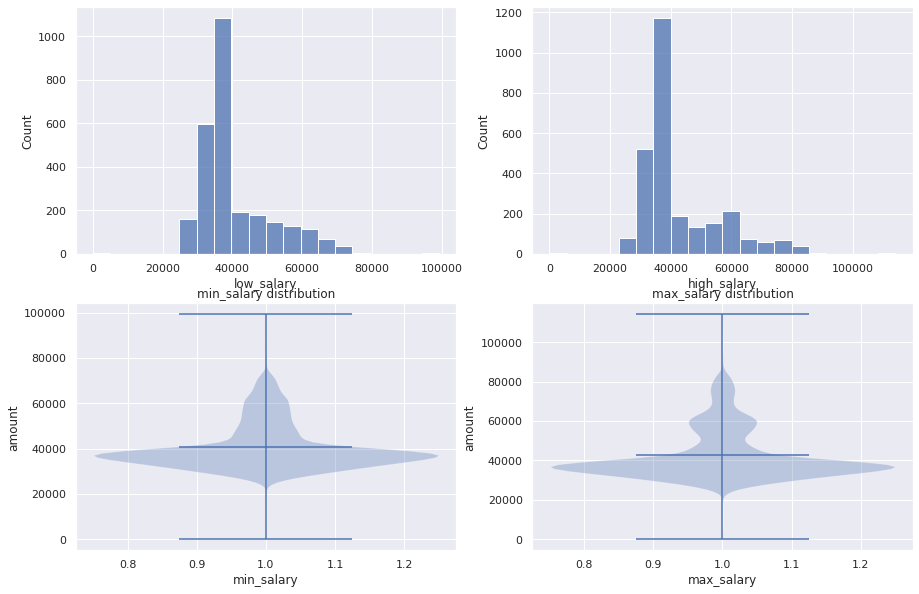

In [107]:
sns.set_theme(style='darkgrid')
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
sns.histplot(df['low_salary'],palette="light:m_r",bins=20, ax= axs[0][0])
sns.histplot(df['high_salary'],palette="light:m_r",bins=20, ax= axs[0][1])
axs[1][0].violinplot(df['low_salary'],showmeans = True)
axs[1][0].set_xlabel('min_salary')
axs[1][0].set_ylabel('amount')
axs[1][0].set_title('min_salary distribution')
axs[1][1].violinplot(df['high_salary'],showmeans = True)
axs[1][1].set_xlabel('max_salary')
axs[1][1].set_ylabel('amount')
axs[1][1].set_title('max_salary distribution')

ANS： There are slight differences between high and low salary from median and mean. However， There are a few outstanding high salaries.

### 2 : What the relation ship between listing time and salary?

<AxesSubplot:xlabel='listing_time_indays'>

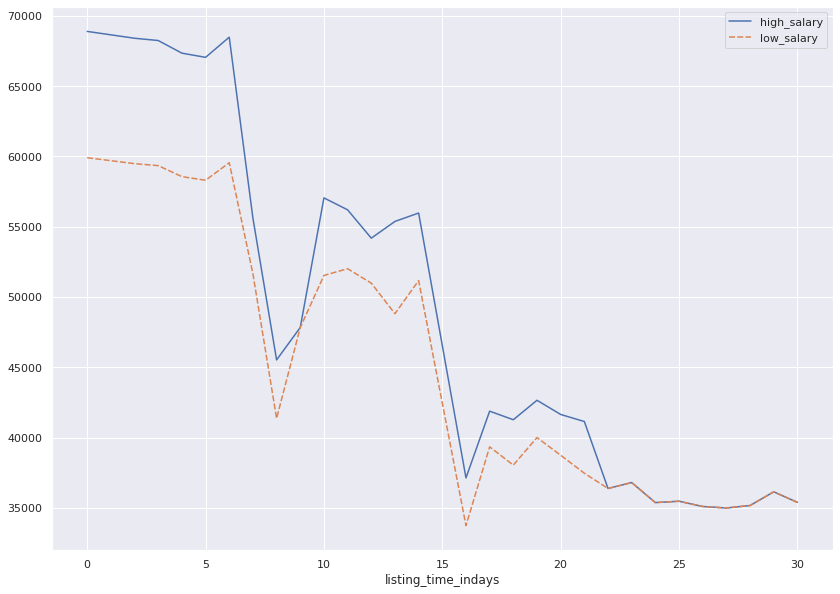

In [108]:
line = df[['listing_time_indays','high_salary','low_salary']].groupby(['listing_time_indays']).mean()
line
plt.figure(figsize=(14,10))
sns.lineplot(data=line)

从线性图中可以很明显的看出工作的发布时间和工作的薪资水平呈反比趋势， 薪水直接决定了该工作在人才市场中的吸引力。

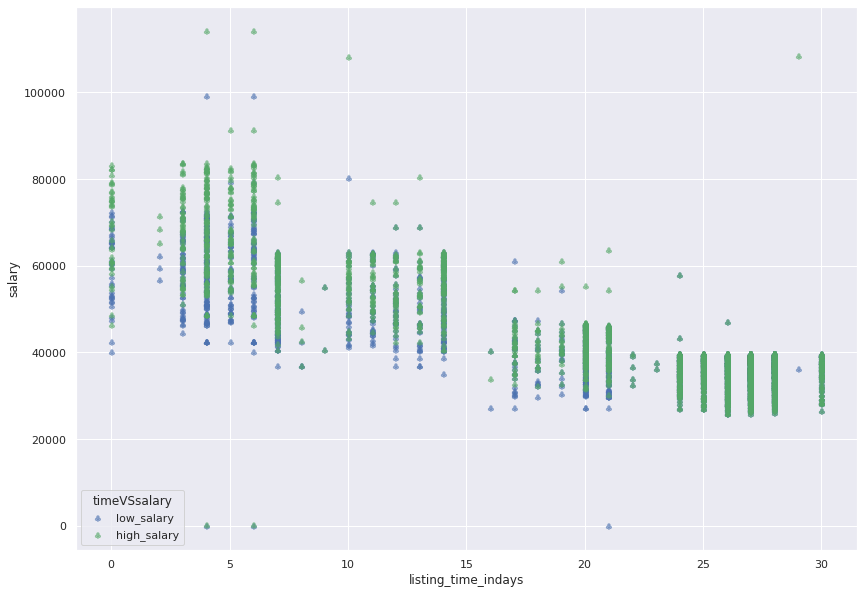

In [110]:
# Fixing random state for reproducibility
np.random.seed(20210326)

df.loc[df['listing_time_indays'] == 29,'high_salary'] = df['high_salary'] * 3

plt.figure(figsize=(14,10))#set the size
x = df['listing_time_indays'].astype(float)
y = df['low_salary']
y1 = df['high_salary']
plt.scatter(x, y, c="b", alpha=0.5, marker=r'$\clubsuit$',
            label="timeVSsalary")
plt.scatter(x, y1, c="g", alpha=0.5, marker=r'$\clubsuit$')
plt.xlabel("listing_time_indays")
plt.ylabel("salary")
plt.legend(['low_salary','high_salary'],
                    loc="lower left", title="timeVSsalary")
plt.show()

In [115]:
df.loc[df['high_salary'] > 100000]['company_name']# 并且某些公司的admin职位的薪水水平远高于其他公司.

278                Madison Recruitment Limited
306                Randstad - Business Support
430    Embassy of the United States of America
609                                   CT Legal
Name: company_name, dtype: object

In [116]:
df.loc[df['listing_time_indays'] ==29]['company_name']# CT Legal 该公司对于该职位的要求较高.

609    CT Legal
Name: company_name, dtype: object

In [ ]:
该散点分布图更清楚的表现了一些比较突出的单一薪水分布， 其中有一些高薪工作仍然在SEEK网站上发布了很长一段时间，这说明在新西兰admin领域中仍在存在部分人才的缺失. 

<ipython-input-117-e6cb69b00f7f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.heatmap(df.groupby('listing_time_indays')['low_salary','high_salary'].mean(),center=45000)


<AxesSubplot:ylabel='listing_time_indays'>

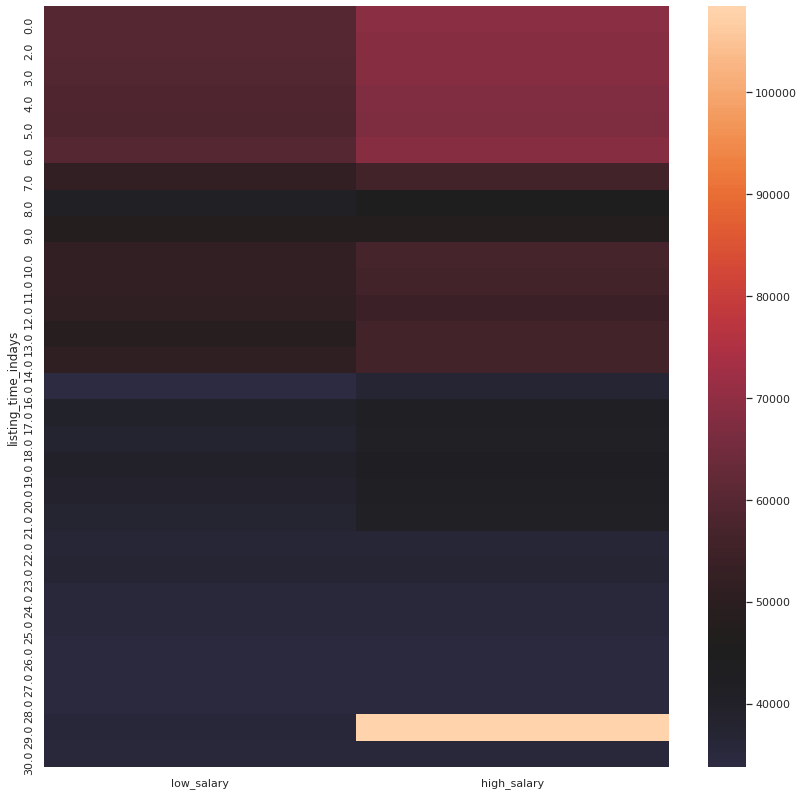

In [117]:
plt.figure(figsize=(14,14))
sns.heatmap(df.groupby('listing_time_indays')['low_salary','high_salary'].mean(),center=45000)

热力图很好的展示了职位的热度和薪水的关系

### 3: Which location has the high-level salaries?

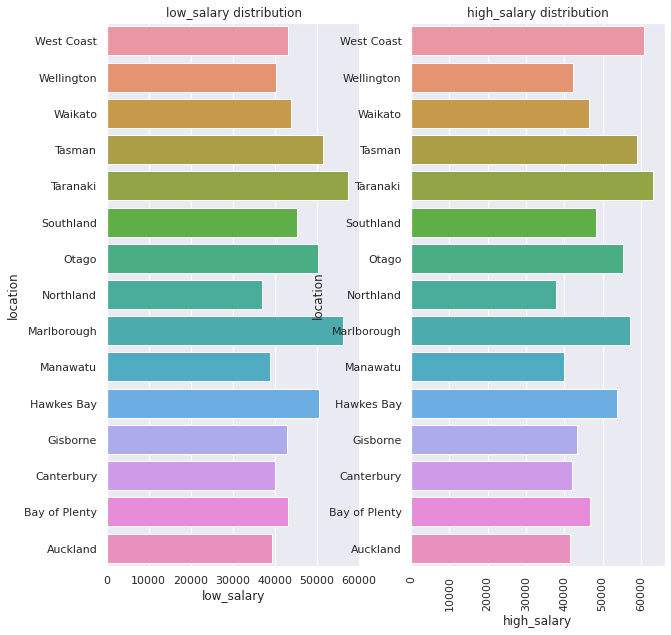

In [118]:
area_salary = df[['location','low_salary','high_salary']].groupby(['location']).mean().reset_index().drop([1,2])

area_salary = area_salary.sort_values(by=['location'],ascending=False)

fig, axs = plt.subplots(nrows = 1, ncols =2, figsize=(10, 10))
sns.barplot(y="location", x="low_salary", data=area_salary, ax=axs[0])
axs[0].set_title('low_salary distribution')
sns.barplot(y="location", x="high_salary", data=area_salary, ax=axs[1])
axs[1].set_title('high_salary distribution')
axs[1].tick_params(axis='x',rotation=90)

In barplot above, we found that the West Coast city has the highest average salary.The gap of the high and low salary in West Coast is largest compair to other cities.  The gap of the high and low salary in Marlborough is smallest，
the salary in this city ismore average. For Auckland and Wellington, which have the most job opportunities, their average salary is not that outstanding.

### 4:  What is the top 10 number of job in locations?

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

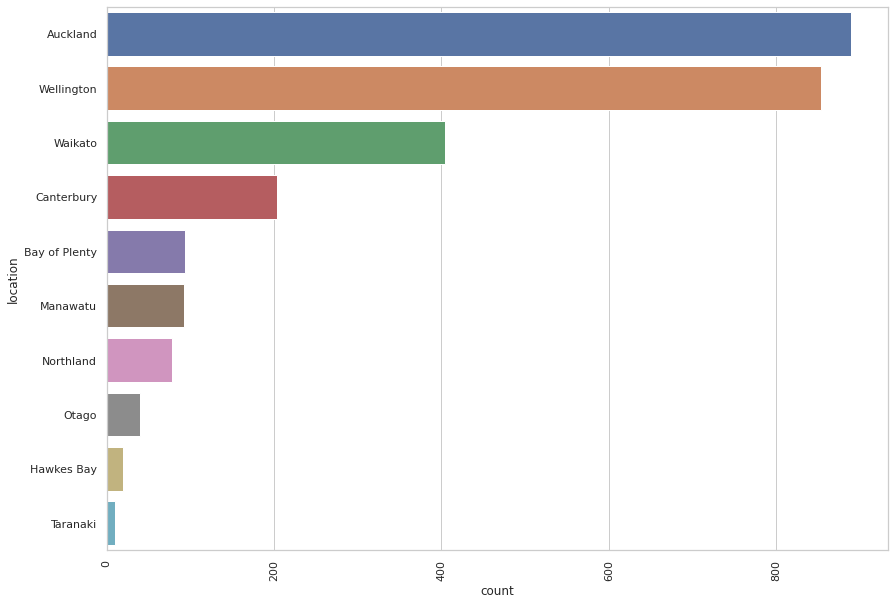

In [123]:
df['count'] = 1
jobplot = df[['location','count']].groupby(['location']).sum().reset_index()
jobplot = jobplot.sort_values(by=['count'],ascending=False).head(10)
plt.figure(figsize=(14,10))
ax =sns.barplot(y="location", x="count", data=jobplot)
plt.xticks(rotation = 90)

<AxesSubplot:>

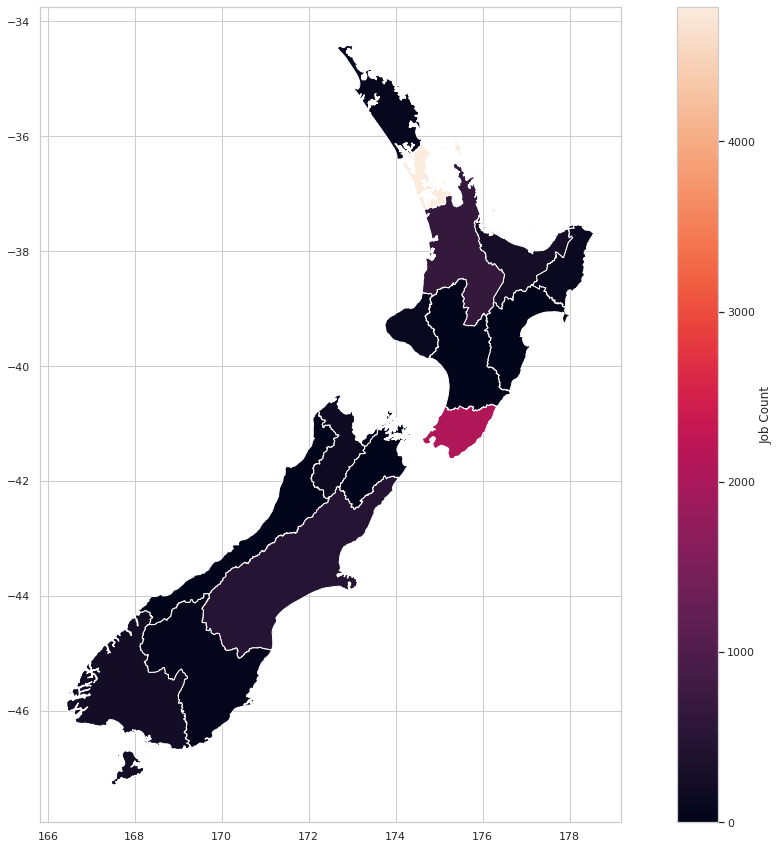

In [127]:
plt.rcParams['figure.figsize'] = [20, 15]
nz = geopandas.read_file("nz_region.geojson")
nz_job_count = pd.read_csv("region_sum.csv")
nz_joined = nz.merge(nz_job_count, on='REGC2016_N')
nz_joined = nz.merge(nz_job_count, on='REGC2016_N', how='left')
nz_joined['JOB_COUNT'].fillna(0, inplace=True)
nz_joined['JOB_COUNT'] = nz_joined['JOB_COUNT'].astype('int')
fig_leg, ax_leg = plt.subplots(1, 1)
nz_joined.plot(column='JOB_COUNT', ax=ax_leg, legend=True, legend_kwds={'label': "Job Count",'orientation': "vertical"})

Auckland and Wellington have more job opportunities than other cities, and the differences are very large. Except for the top five major cities, other cities have no demand for this job.

### 5: Is premotion effective in NZ SEEK? What is the most popular job?

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Office Management'),
  Text(1, 0, 'Receptionists'),
  Text(2, 0, 'Other'),
  Text(3, 0, 'Administrative Assistants'),
  Text(4, 0, 'Client & Sales Administration'),
  Text(5, 0, 'Data Entry & Word Processing'),
  Text(6, 0, 'PA, EA & Secretarial'),
  Text(7, 0, 'Contracts Administration'),
  Text(8, 0, 'Records Management & Document Control')])

<Figure size 1008x720 with 0 Axes>

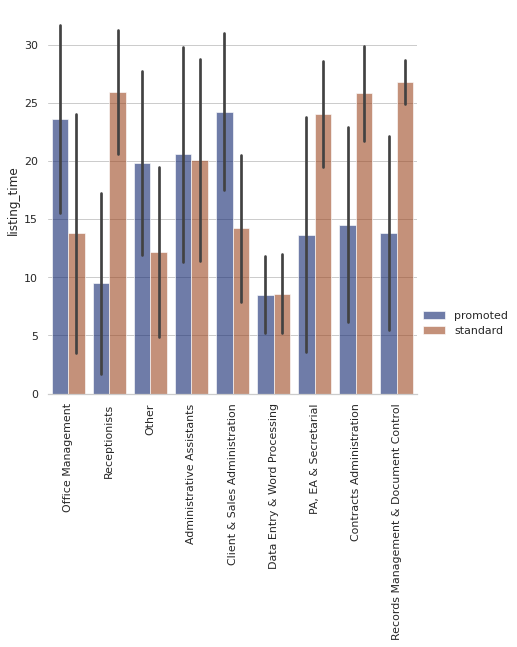

In [119]:

df.loc[df['ad_type'].str.contains('standout'),'ad_type'] = 'promoted'
df.loc[df['Classification'].str.contains('unknow'),'Classification'] = 'Other'

sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
plt.figure(figsize=(14,10))
y1=df["listing_time_indays"].astype(int)
g = sns.catplot(
    data=df, kind="bar",
    x="Classification", y=y1, hue="ad_type",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "listing_time")
g.legend.set_title("")
plt.xticks(rotation = 90)

<AxesSubplot:xlabel='ad_type', ylabel='listing_time_indays'>

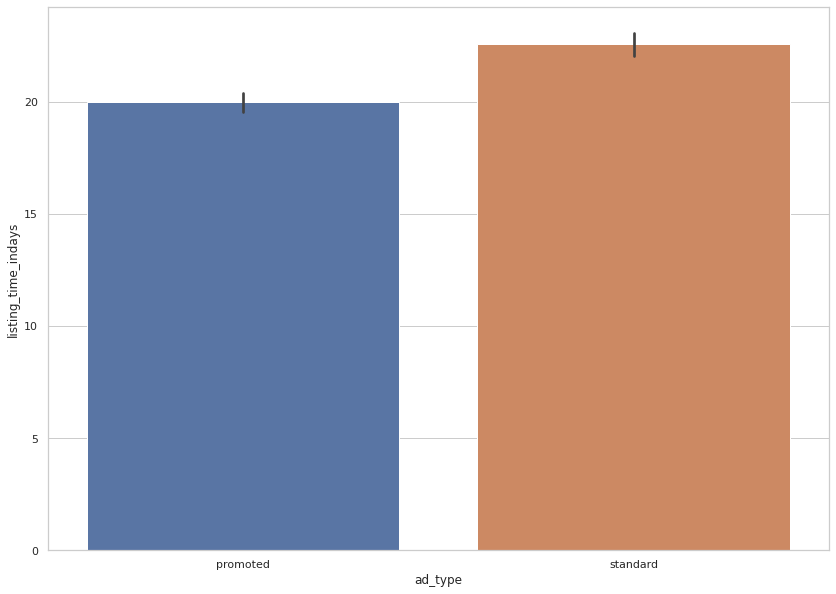

In [22]:
plt.figure(figsize=(14,10))
sns.barplot(y=y1, x="ad_type", data=df)


The most popular job is Data Entry. And promoted recruitment advertisements in NZ SEEK are not obvirously effective.

Now we disscuss why Data Entry is the most popular job.

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

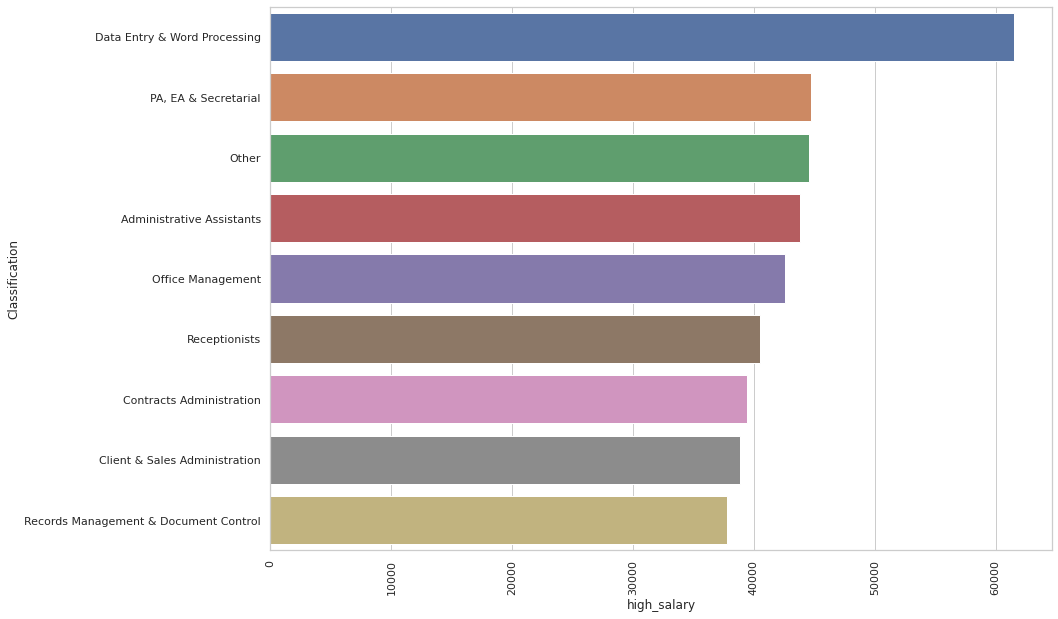

In [120]:
job_salary=df[['high_salary',"Classification"]].groupby(["Classification"]).mean().reset_index().sort_values(by=['high_salary'],ascending=False)
plt.figure(figsize=(14,10))
sns.barplot(x='high_salary', y="Classification", data=job_salary)
plt.xticks(rotation = 90)

The reason why data entry is most popular job is the salary of data entry is highest.